## Introduction

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 

import importlib

import os
import sys
sys.path.append("../")
import methods  
importlib.reload(methods)


<module 'methods' from '/Users/timothysudijono/Projects/statistics/empirical_bayes/CompoundWelfareMaximization/analyses/../methods.py'>

In [26]:
def visualize(df, threshold = 1.96):
    fig, ax = plt.subplots(1,2, figsize = (9,3))
    ax[0].scatter(df["treatment_effects"], df["standard_errors"], s = 10)
    ax[0].set_xlabel("Treatment Effects")
    ax[0].set_ylabel("Standard Errors")
    ax[0].set_title("TEs vs Std. Errors")

    tstat_threshold = threshold

    mask = (df["tstats"] > tstat_threshold)
    masked_df = df.loc[mask,:]
    ax[0].scatter(masked_df["treatment_effects"],
                masked_df["standard_errors"],
                s = 10, color = "orange")

    xs = np.linspace(-0.3,0.3)
    ax[0].plot(xs, xs/tstat_threshold,color = "orange", linestyle = "dashed")
    ax[0].set_ylim(0,0.10)

    ax[1].hist(df["treatment_effects"], bins = 50)
    ax[1].set_xlabel("Treatment Effects")
    ax[1].set_ylabel("Counts")
    ax[1].set_title("TE Histogram")

    print(df["treatment_effects"].describe())
    print(df["tstats"].describe())

In [27]:
df = pd.read_csv("data/example_te_data.csv").iloc[:,1:]
df["tstats"] = df["treatment_effects"]/df["standard_errors"]
df.head(10)
print(df.shape)

(331, 3)


count    331.000000
mean      -0.001054
std        0.040053
min       -0.292068
25%       -0.018554
50%       -0.000391
75%        0.017583
max        0.283918
Name: treatment_effects, dtype: float64
count    331.000000
mean       0.006638
std        2.113950
min      -17.578332
25%       -0.859540
50%       -0.016313
75%        0.855104
max       21.472638
Name: tstats, dtype: float64


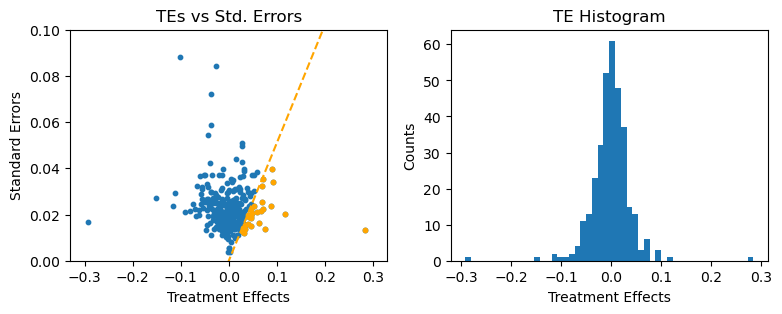

In [28]:
visualize(df)
plt.savefig("experimentation_program_viz.pdf", bbox_inches = 'tight')

## Method

Let $X_i,\sigma_i$ be the treatment effect estimates and standard deviation estimates. We will consider rules of the form $X_i > C\sigma_i$ and choose the optimal $C$ based on the SURE method. The SURE method minimizes the following curve:
$$
\widehat{W}_n(C) := \sum_{i=1}^n X_i \mathbf{1}\set{X_i \geq C\sigma_i} - \sum_{i=1}^n \sigma_i h_n\left(\frac{X_i}{\sigma_i} - C \right)
$$
with $h_n$ a rescaled version of the Fourier Integral Estimate kernel given by $h_n(x) = \frac{\sin(\sqrt{2\log n}x)}{\pi x}.$ The true welfare of a decision threshold $C$ would be given by
$$
\sum_{i=1}^n \mu_i \mathbb{P}(X_i \geq C \sigma_i)
$$

Optimal Threshold: -0.010020040080160442


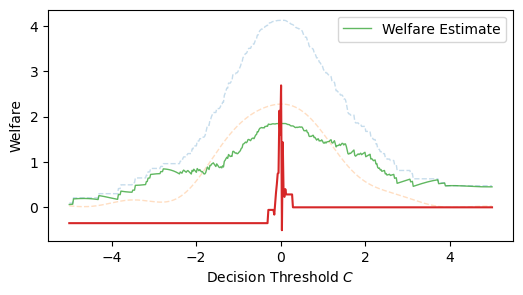

In [31]:
importlib.reload(methods)

Xs = np.array(df["treatment_effects"])
sigmas = np.array(df["standard_errors"])


cb_welfare = methods.coupled_bootstrap(Xs, sigmas, eps = 0.01)
grid = np.linspace(-5, 5, len(cb_welfare))


res = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, smoothen_nn=False)

plt.plot(grid, cb_welfare)

#plt.title("Welfare Estimates for Experimentation Programs")
#plt.savefig("experimentation_program_welfare_curve.pdf", bbox_inches='tight')

## Some synthetic simulation examples

The above threshold seems very different than 1.96. How much confidence can we place in this recommendation? Is the scaling of the dataset okay?

Synthetic data setting will be: true TEs will be the old dataset; new noise will be generated by adding to standard deviation.

In [32]:
np.random.seed(17)
true_effects = df.treatment_effects
synth_df = df.copy()
synth_df["treatment_effects"] += np.random.normal(0,synth_df["standard_errors"]) 
synth_df["tstats"] = synth_df["treatment_effects"]/synth_df["standard_errors"]

count    331.000000
mean      -0.001273
std        0.049738
min       -0.306410
25%       -0.022560
50%       -0.001253
75%        0.022291
max        0.276661
Name: treatment_effects, dtype: float64
count    331.000000
mean       0.014201
std        2.394484
min      -18.441501
25%       -1.148936
50%       -0.073646
75%        1.128386
max       20.923841
Name: tstats, dtype: float64


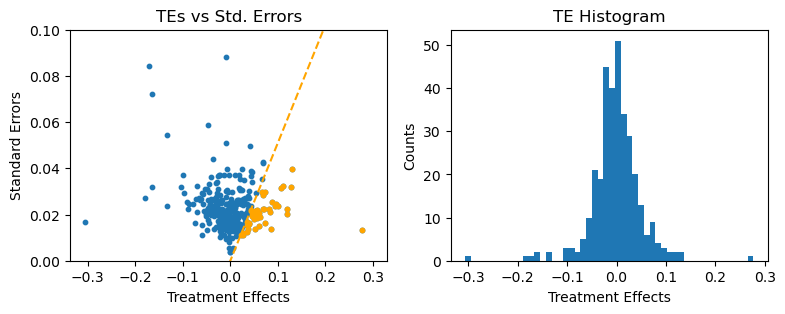

In [33]:
visualize(synth_df)

Optimal Threshold: 0.2104208416833666
True Optimal Threshold: 0.030060120240480437


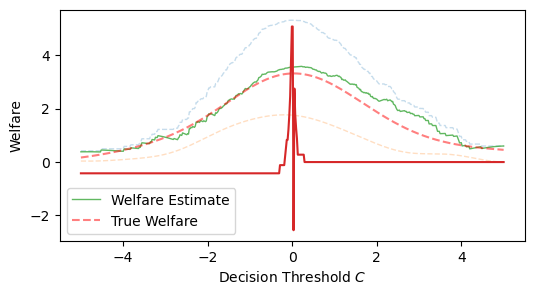

In [36]:
import scipy

Xs = np.array(synth_df["treatment_effects"])
sigmas = np.array(synth_df["standard_errors"])
_ = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, true_effects=true_effects, smoothen_nn=False)


cb_welfare = methods.coupled_bootstrap(Xs, sigmas, eps = 0.001)
grid = np.linspace(-5, 5, len(cb_welfare))
plt.plot(grid, cb_welfare, label = "CB estimate")

#plt.savefig("results/experimentation_program_validation.pdf", bbox_inches = 'tight')


### Noise Misspecification

In [24]:
np.random.seed(17)
true_effects = df.treatment_effects
synth_df = df.copy()
synth_df["treatment_effects"] += np.random.normal(0,synth_df["standard_errors"]) 

# add misspecification to standard error
synth_df["standard_errors"] *= 1 + np.random.normal(0,0.21)
synth_df["tstats"] = synth_df["treatment_effects"]/synth_df["standard_errors"]

Optimal Threshold: 0.2505010020040075
True Optimal Threshold: 0.030060120240480437


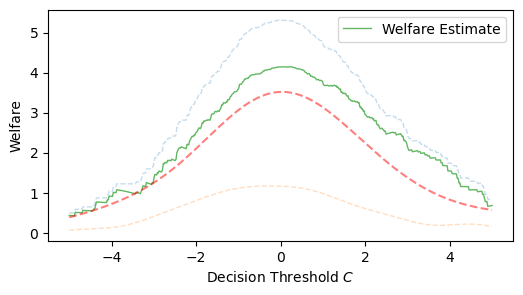

In [25]:
Xs = np.array(synth_df["treatment_effects"])
sigmas = np.array(synth_df["standard_errors"])
_ = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, true_effects=true_effects)


#### Distribution Misspecification

Optimal Threshold: -0.29058116232464926
True Optimal Threshold: 0.030060120240480437


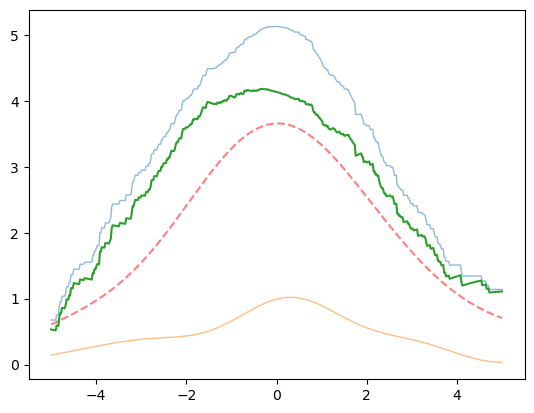

In [82]:
np.random.seed(17)
true_effects = df.treatment_effects
synth_df = df.copy()
dof = 20

# t distributed noise with the proper variance.
synth_df["treatment_effects"] += ((dof - 2)/dof)*np.random.standard_t(dof, size = len(true_effects))*synth_df["standard_errors"] 

# add misspecification to standard error
synth_df["standard_errors"] *= 1 + np.random.normal(0,0.21)
synth_df["tstats"] = synth_df["treatment_effects"]/synth_df["standard_errors"]

Xs = np.array(synth_df["treatment_effects"])
sigmas = np.array(synth_df["standard_errors"])
_ = methods.heteroskedastic_normal_welfare_estimator(Xs, sigmas, true_effects=true_effects)(Xs, sigmas, true_effects=true_effects)